Tommaso Peritore

In [1]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#scipy
import scipy
from scipy.special import erf

#numpy
import numpy as np
from numpy import exp
from numpy.lib.scimath import log, sqrt

#glob
import glob 

#fit
from scipy.optimize import curve_fit

# Exercise 3

## 3.1

By using the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

compute at time $t=0$ **via Monte Carlo** the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$:

1. By sampling **directly** the final asset price $S(T)$ for a $GBM(r,\sigma^2)$
2. By sampling the discretized $GBM(r,\sigma^2)$ path of the asset price dividing $[0,T]$ in $10^2$ time intervals: $S(0)$, $S(t_1)$, $S(t_2)$, ... up to $S(t_{100}=T=1)$

Remember that given an asset price $S\sim GBM(\mu,\sigma^2)$, with initial value $S(0)$, then
$$S(t) = S(0) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]$$
where $W(t)\sim\mathcal{N}(0,t)$.
Moreover, since the increments of $W$ are independent and normally distributed, the simple recursive procedure for sampling discretized values of $S\sim GBM(\mu,\sigma^2)$ at $t_1 < t_2 < … < t_n$ is:
$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i) +\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$
with $Z_i \sim \mathcal{N}(0,1)$

Make four pictures for the estimation of the European call-option prices, $C[S(0),0]$ (direct and discretized), and put-option prices, $P[S(0),0]$ (direct and discretized), with their uncertainties with a large number of asset prices at time $t=T$, say $M\ge 10^4$, as a function of the number of blocks, $N$.  As usual, in computing statistical uncertainties, use data blocking.

#### For comparison, Black-Scholes analytic solution

In [2]:
# data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call, put = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK-SCHOLES ==")
    print("call: ", call)
    print("put: ", put)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


## Lecture notes

#### Brownian motion 

The goal of studying processes in nature which involve some sort of stochastic behavior showed the need to develop new formalisms, able to handle non differentiable trajectories, called **stochastic calculus**. It generalized ordinary differential equations to describe also paths that evolve in a non deterministic fashion.

A first example of a use case scenario of stochastic calculus is the **Brownian motion**, that is when things appear to be in a constant state of agitation, undergoing rapid and random movements.
In 1923 Wiener developed a rigourous theory for the Brownian motion, in specific showing how this process can be sampled via a Random Walk with i.i.d. normal increments:
$$ W(t_{i+1}) = W(t_i) + Z_{i+1}\sqrt{t_{i+1}-t_i}  \;\; i=0,1,... $$
<br> Thus formalized, the Wiener process has some interesting characteristics:
- it has continous sample paths which are nowhere differentiable
- the process is self-similar, i.e. any finite portion of W(t) when properly rescaled is (statistically) indistinguishable from the whole path

#### Itô stochastic integral

We take a function $G(t)$ over an interval $(t_0,t_n)$ which we want to define an integral for but with a measure given by $dW(t)$ with $W(t)$ our Wiener process. As with Riemann integrals, we partition the interval into subintervals $(t_0,t_1), (t_1,t_2), ... , (t_{n-1},t_n)$ and define the set of points $\tau_i$ inside the intervals, $t_{i-1}<\tau_i<t_i$.
<br> We need to define the mean-square limit as
$$  \underset{n\rightarrow\infty}{ms-lim} \, X_n = X \; \iff \; \lim_{n\rightarrow\infty} \left\langle (X_n - X)^2 \right\rangle = 0 $$
Which allows us to define 
$$ \int_{t_0}^{t_n} G(t')dW(t') := \, \underset{n\rightarrow\infty}{ms-lim} \, \sum_{i=1}^n G(\tau_i)\left[W(t_i)-W(t_{i-1})\right] $$
This is a definition of convergence in the mean-square limit, weaker requirement than the point-wise convergence for the Riemann integral.
<br> To define the integral unquiely, however, we need to make a choice of $\left\{\tau_i\right\}$. The **Itô stochastic integral** makes the choice of $\tau_i = t_{i-1}$, thus defining a pretty useful integral due to its mathematical propoerties which made it rather popular in literature.
<br> With the use of **non-anticipating** functions, a sort of casuality requirement, where the function does not anticipate the future behavior of the Wiener process, one can also go on with definining the **stochastic differential equation** (SDE) through the stochastic integral

#### Generating sample paths

There are two ways to go about simulating paths of stochastic processes. An **exact simulation** is only allowed for simpler models, while more complex ones may require some **discretization** of the stochastic differential equation.
<br> The first method can be considered exact in the sense that the joint distribution of the simulated values coincides with that of the continuous-time process.
<br> We define a process $X(t)$ as a Brownian motion with *drift $\mu$* and *diffusion coefficient $\sigma^2$*, abbreviated $X \sim BM(\mu,\sigma^2)$ if
$$ \frac{X(t)-\mu t}{\sigma} \sim BM(0,1)$$ 
i.e. it is a standard Bronian motion. This allows to construct $X$ from a standard Brownian Motion $W$.
<br> The above was defined with constant drift and diffusion coefficient. For deterministic, but time-varying $\mu(t)$ and $\sigma(t)$ one can define the Brownian motion with a more complex SDE.

Now we can define the exact method for sampling the Brownian motion.
<br> Let $Z_1, ... , Z_n$ be independent standard normal random variables $(Z_i\sim\mathcal{N}(0;1))$, set $t_0=0$ and $W(0)=0$ and the subsequent values of the process are generated, as already mentioned above, as
$$ W(t_{i+1} = W(t_i) + Z_{i+1}\sqrt{t_{i+1}-t_i}  \;\; i=0,1,...,n-1 $$
and for $X \sim BM(\mu,\sigma^2)$, given $X(0)=0$ the path can be obtained as 
$$X(t_{i+1}) = X(t_i) + \mu(t_{i+1}-t_i) + \sigma Z_{i+1}\sqrt{t_{i+1}-t_i} \;\; i=0,1,...,n-1 $$

#### Financial markets

Despite being at first ignored, Bachelier's mathematics of Brownian motion were taken up by Itô to introduce **geometric Brownian motion** (GBM) a variant of BM that became important for financial markets as confirmed in P.A. Samuelson's works of 1965 which received the Nobel Prize in Economics in 1970. In 1973, GBM was used to develop a theory to determine price of stock options, achievement of huge importance for mathematical finance (also awarded the Nobel Prize in Economics to Scholes and Merton in 1997).

Due to the fact that the valuation formulas have proved to be all but perfect, with widely documented discrepancy between theory and application, physicists have recently began exploring the reason behind these observed discrepancies, giving rise to an independent field called **econophysics**, where the financial markets are modeled as complex many-body systems.

Let us introduce some basic notion of financial markets
- a *market* is a place where buyers and sellers meet to exchange products, which have a price at every time $t$, the spot price $S(t)$
- the *spot price* is determined by the interplay of supply and demand
- the *financial market* is a special market where money is traded as the product, usually lent, borrowed or invested in commodities and securities such as bonds or stocks 
- *contracts* are stipulated between market participants, *agents*, that are willing to accept a certain amount of *risk* for the possibility of big profits in return
- *risk management* is anything that tries to minimize risk of potential losses, and is the main reason why physicists and mathematicians get involved in finance

In a financial market, the evolution of values over time is extremely unpredictable, but not because it does not reflect economic information, but rather for the abundance of this information, making it hard to correlate economic information with a specific aspect of values evolution. 

A market is called *efficient* if agents can easily obtain information necessary for trading, if it is liquid, i.e. products can be sold or bought at all times, and if costs for transactions are negligible compared to the transaction volumes. Real markets are only approximately efficient, which leads to the **Markow assumption** which has been by now widely verified. If price of a certain product is predicted to rise, investors would buy it to sell it later to tgain the difference. However, the market responds to the increase in demand elevating the price of the product, making the profitable opportunity vanish in a short period. This limits any correlation of future price with current state of the asset to a very short time range, advocating for the randomness of time series.

#### Modeling financial markets

Let's assume we deposit at time $t=0$ a sum $S(0)$ in the bank. If we are granted an interest rate $r$, by the time we receive the interest, our sum has grown by
$$ S(t) = S(0) + rtS(0) = S(0)(1+rt)$$
whereas if we were to ask for the interest to be paid multiple times, in the limit our sum would follow
$$ S(t) = S(0)\left(1 + \frac{rt}{n}\right)^n \underset{n\rightarrow\infty}{\rightarrow} S(0)e^{rt}$$
Now we may introduce stochastic fluctuations which can perturbate the price. The price change $dS$ in the small time interval $dt$ would have a deterministic and a stochastic contribution:
$$ d S(t) = \mu S(t) dt + \sigma S(t) dW(t)$$
where the first term is deterministic, with $\mu$, called *drift*, measuring the average growth rate of the asset price, and the second term is stochastic, with $\sigma$ being the *volatility* which measures the strength of the statistical price fluctuations. This SDE defines a variant of Brownian motion, which is called geometric Brownian motion.
<br> The relevant variable is actually the return $dS/S(t)$ which allows us to use Itô formula to find that $S(t)$ is log-normally distributed, and we will use the notation $S(t)\sim GBM(\mu,\sigma^2)$. Thus we can evaluate $S(t)$ with initial value $S(t')$ with $t'< t$ as 
$$ S(t) = S(t') \exp \left[ \left( \mu - \frac{\sigma^2}{2} \right)\left(t-t'\right) + \sigma \left( W(t)-W(t') \right) \right] $$
which is the formula for **direct sampling** that will be used in our code. 
<br> Subsequently, a simple recursive procedure can be easily derived from the above, knowing that increments of $W$ are independently and normally distributed. Sampling at $0=t_0 < t_1 < ... < t_n$ the formula for **indirect sampling** is
$$ S(t_{i+1}) = S(t_i) \exp \left[ \left( \mu - \frac{\sigma^2}{2} \right)\left(t_{i+1}-t_i\right) + \sigma Z_{i+1}\sqrt{t_{i+1}-t_i} \right] $$
which is in exact method in the distribution sense, as explained above.

#### Options

Simply puy, options are kinds of contracts where one end assumes the obligation, and the other obtains a right. The simplest types are European for this reason also called plain vannilla options. The seller of the option, a.k.a. the *writer* grants the buyer, the *holder*, the right to purchase (**call option**) or sell (**put option**) to him an underlying with a current spot price $S(t)$ for a determined price of $K$ called *strike price* at the *expiry date* $T$. The holder will choose whether to buy or sell depending on the profit.
$$ P_{call} = \max \left[0, S(T)-K\right] \qquad P_{put}= \max \left[0, K-S(T)\right] $$
The problem is then to correctly price these options, and in general there are much more complex options, which require numerical (Monte Carlo) techniques. This is what Black-Scholes theory tackles this problem for European options.

**Black-Scholes theory** assumes that the time evolution of the asset price is stochastic and exhibits geometric Brownian motion (GBM) with constant risk-free interest rate $r$ and volatility $\sigma$.

Black-Scholes analytic solution for the price at time $t<T$ :
- European Call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- European Put-option price:
$$ P\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$
where 
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]$$
where $d_2 = d_1 - \sigma\sqrt{T-t}$, and where
$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$
is the cumulative of Gaussian $\sim \mathcal{N}(\mu=0,\sigma^2=1)$, and where
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}$$

Considering an asset with price $S(t)$ and an European call option, to obtain the present value of the profit (at time $t$) we have to discount it by a factor $e^{-rT}$ due to the interest that a Bank would have guaranteed with a deposit at time $t_0=0$, with the calculation of the option price now corresponding to the expectation value for the discounted profit on the distribution of the prices at expiry
$$\left\langle e^{-rT}\left(S(T)-K\right)^+ \right\rangle $$
this is in fact the estimate of what the holder of the option would have to pay at $t=0$ on the basis of the expected profit at time $t=T$, which can be obtained with a Monte Carlo simulation algorithm.

## Solution

#### General comments on simulation and code

All the code for the simulation is inside the file `main.cpp`, this time there was no need to implement an outside library of functions, as the only one was the calculation of the error for block averaging. 

The code is divided into direct sampling and indirect sampling, and they were executed in two different *for loops* mainly for readability.

Block averaging was executed with the following parameters
- `iterations` $ M = 10^6$
- `blocks` $N = 100$
- `blockSize` $L = M/N = 10000$

The output files where collected in the directory `./3/Data` and differentiated for *call* and *put* options and the two versions of the simulation.

All parameters are initialized in the `main` function and are set to the values assigned in the exercise.

Finally, the results were compared to the expectation values obtained through the Black-Scholes theory which was solved analytically. They were given in the exercise and were
$$S(T)_{exp}^{call} = 14.97579 \qquad S(T)_{exp}^{put} = 5.45953$$

#### Direct sampling

The code implemented for direct sampling was quite straight-forward. Inside the `for` loops used for blocking average, the following code was used to calculate simultaneously $S(T)$, $C(T,0)$ and $P(T,0)$

```` cpp
rand = rnd.Gauss(0, T) ;														
S_T = S_0 * exp( (r - 0.5*pow(sigma,2)) * T + (sigma * rand) ) ;       
call += std::max(0., S_T - K) * exp (- r * T) ;                       	
put += std::max(0., K - S_T)* exp (- r * T) ;
````

and the data collected is shown below.  

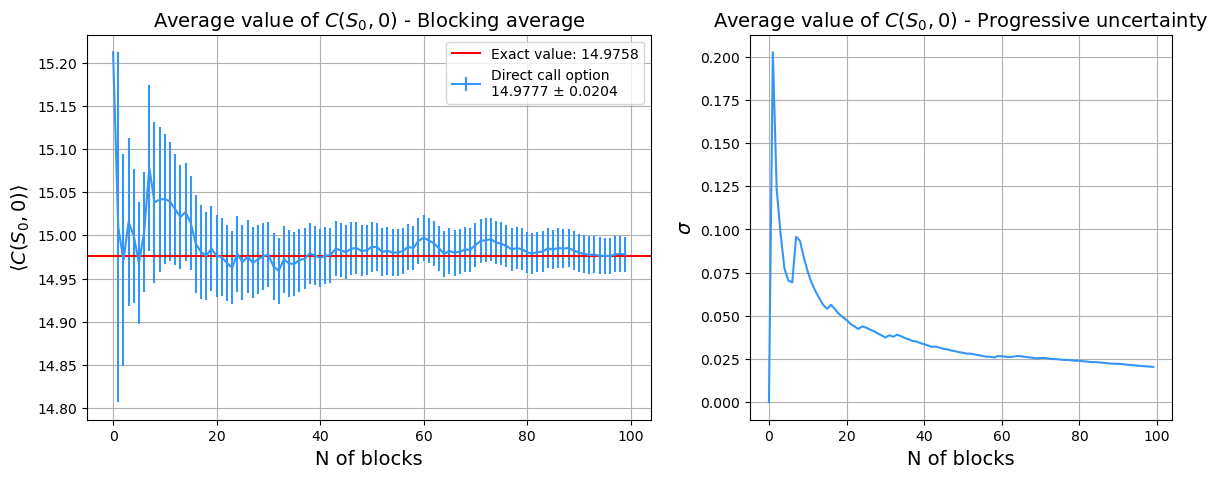

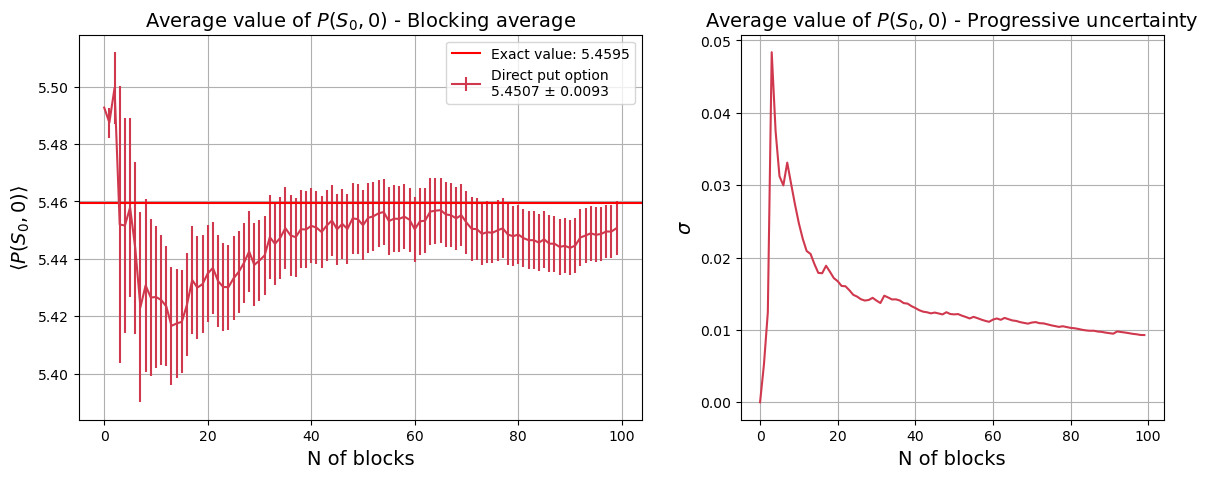

In [3]:
# --------- Call Option - Direct sampling ---------

#data acquisition
x_label, progressive_sum, progressive_error = np.loadtxt('./3/Data/call_direct.dat', unpack = True, usecols = (0, 1, 2))
#style
fig, axs = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [2, 1.5]}, figsize = (14, 5))

#plot 1
axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error, c = '#3496f7',
                label = "Direct call option\n"+ str(round(progressive_sum[-1],4)) + " ± " + str(round(progressive_error[-1],4)))
axs[0].axhline(14.975790778311286, ls = '-', c = 'red', label = "Exact value: 14.9758")
#style plot 1
axs[0].set_xlabel('N of blocks', fontsize = 14)
axs[0].set_ylabel(r'$\left\langle C(S_{0},0)\right\rangle$', fontsize = 14)
axs[0].grid(True)
axs[0].set_title('Average value of $C(S_{0},0)$ - Blocking average', fontsize = 14)
axs[0].legend()

#plot 2
axs[1].plot(x_label, progressive_error, c = '#3496f7', label = "Progressive uncertainty")
#style plot 2
axs[1].set_ylabel('$\sigma$', fontsize = 14)
axs[1].set_xlabel('N of blocks', fontsize = 14)
axs[1].set_title('Average value of $C(S_{0},0)$ - Progressive uncertainty', fontsize = 14)
axs[1].grid(True)

plt.show()


# --------- Put Option - Direct sampling ---------

#data acquisition
x_label, progressive_sum, progressive_error = np.loadtxt('./3/Data/put_direct.dat',
                                                          unpack = True, usecols = (0, 1, 2))

#style
fig, axs = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [2, 1.5]}, figsize = (14, 5))

#plot 1
axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error, c = '#d0384e', 
                label = "Direct put option\n"+ str(round(progressive_sum[-1],4)) + " ± " + str(round(progressive_error[-1],4)))
axs[0].axhline(5.4595325819072364, ls = '-', c = 'red', label = "Exact value: 5.4595")
#style plot 1
axs[0].set_xlabel('N of blocks', fontsize = 14)
axs[0].set_ylabel(r'$\left\langle P(S_{0},0)\right\rangle$', fontsize = 14)
axs[0].grid(True)
axs[0].set_title(r'Average value of $P(S_{0},0)$ - Blocking average', fontsize = 14)
axs[0].legend()

#plot 2
axs[1].plot(x_label, progressive_error, c = '#d0384e', label = "Progressive uncertainty")
#style plot 2
axs[1].set_ylabel(r'$\sigma$', fontsize = 14)
axs[1].set_xlabel('N of blocks', fontsize = 14)
axs[1].set_title(r'Average value of $P(S_{0},0)$ - Progressive uncertainty', fontsize = 14)
axs[1].grid(True)

plt.show()

The simulation for both options gave a final value that is evidently well within a single unit of $\sigma$ from the expected value.

#### Indirect sampling

To sample the asset price indirectly, the time interval $[0,T]$ was divided into $100$ `steps` making for the size of each step, in the code called `increment` to be equal to  $T/100 = 0.01 $. Once again inside the two `for` loops for blocking average, the following code was added

````cpp
S_T = S_0 ;

for (int k = 0; k < steps; k++){
	rand = rnd.Gauss(0,1);
	S_T *= exp((r - 0.5*pow(sigma,2)) * increment + (sigma * rand * sqrt(increment)));     
}
````
while *call* and *put* options estimates were calculated as shown in the direct sampling portion.
Collected data is shown in the graphs below.

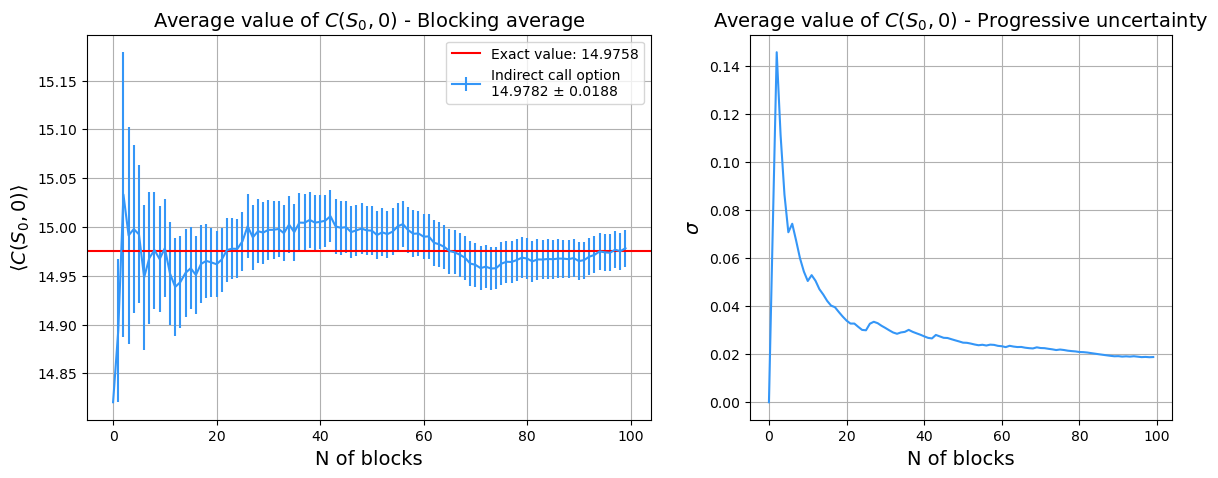

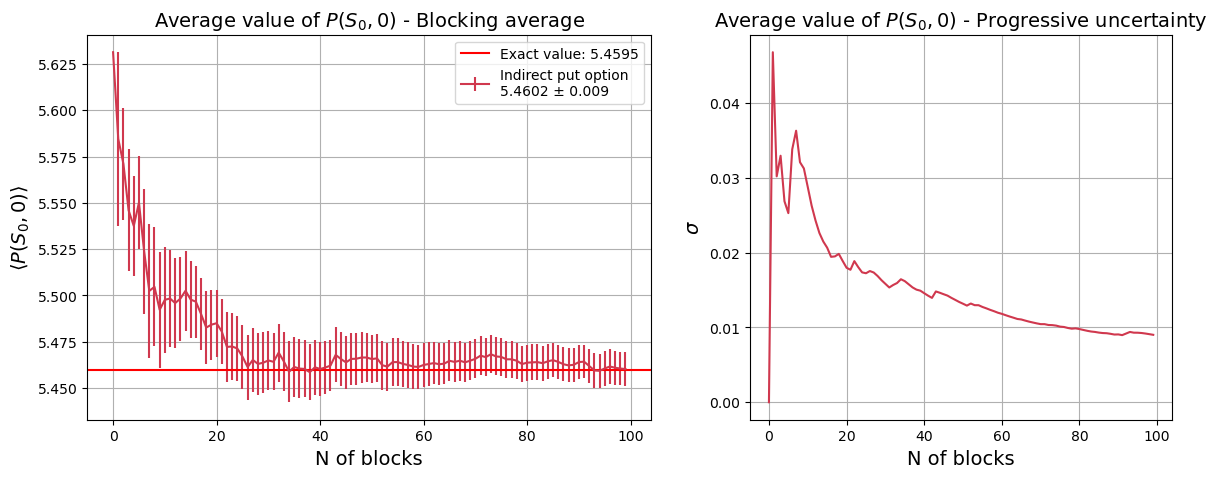

In [4]:
# --------- Call Option - Indirect sampling ---------

#data acquisition
x_label, progressive_sum, progressive_error = np.loadtxt('./3/Data/call_indirect.dat',
                                                          unpack = True, usecols = (0, 1, 2))
#style
fig, axs = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [2, 1.5]}, figsize = (14, 5))

#plot 1
axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error, c = '#3496f7', 
                label = "Indirect call option\n"+ str(round(progressive_sum[-1],4)) + " ± " + str(round(progressive_error[-1],4)))
axs[0].axhline(14.975790778311286, ls = '-', c = 'red', label = "Exact value: 14.9758")
#style plot 1
axs[0].set_xlabel('N of blocks', fontsize = 14)
axs[0].set_ylabel(r'$\left\langle C(S_{0},0)\right\rangle$', fontsize = 14)
axs[0].grid(True)
axs[0].set_title('Average value of $C(S_{0},0)$ - Blocking average', fontsize = 14)
axs[0].legend()

#plot 2
axs[1].plot(x_label, progressive_error, c = '#3496f7', label = "Progressive uncertainty")
#style plot 2
axs[1].set_ylabel('$\sigma$', fontsize = 14)
axs[1].set_xlabel('N of blocks', fontsize = 14)
axs[1].set_title('Average value of $C(S_{0},0)$ - Progressive uncertainty', fontsize = 14)
axs[1].grid(True)

plt.show()


# --------- Put Option - Indirect sampling ---------

#data acquisition
x_label, progressive_sum, progressive_error = np.loadtxt('./3/Data/put_indirect.dat',
                                                          unpack = True, usecols = (0, 1, 2))

#style
fig, axs = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [2, 1.5]}, figsize = (14, 5))

#plot 1
axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error,  c = '#d0384e', 
                label = "Indirect put option\n"+ str(round(progressive_sum[-1],4)) + " ± " + str(round(progressive_error[-1],4)))
axs[0].axhline(5.4595325819072364, ls = '-', c = 'red', label = "Exact value: 5.4595")
#style plot 1
axs[0].set_xlabel('N of blocks', fontsize = 14)
axs[0].set_ylabel(r'$\left\langle P(S_{0},0)\right\rangle$', fontsize = 14)
axs[0].grid(True)
axs[0].set_title(r'Average value of $P(S_{0},0)$ - Blocking average', fontsize = 14)
axs[0].legend()

#plot 2
axs[1].plot(x_label, progressive_error, c = '#d0384e', label = "Progressive uncertainty")
#style plot 2
axs[1].set_ylabel(r'$\sigma$', fontsize = 14)
axs[1].set_xlabel('N of blocks', fontsize = 14)
axs[1].set_title(r'Average value of $P(S_{0},0)$ - Progressive uncertainty', fontsize = 14)
axs[1].grid(True)

plt.show()

Here we observe an improvement for the *put* option, getting closer at the end of the simulation to the actual value compared to the direct sampling outcome. On the other hand, the opposite is true for the *call* option, which saw in the indirect sampling a slight worsening of the estimation. However these results are well within a single $\sigma$ of the exact value.